In [78]:
import os

import matplotlib.pyplot as plt
import numpy as np

In [114]:
RNG_SEED = 42

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 22})
np.random.seed(seed=RNG_SEED)


def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Source: https://jwalton.info/Matplotlib-latex-PGF/"""
    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27
    golden_ratio = (5**.5 - 1) / 2
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    return (fig_width_in, fig_height_in)

In [115]:
class ToyDataset:
    def __init__(self, size):
        self.size = size
        mask = np.random.binomial(1, 0.8, size=(size // 2,))[:, None]
        g1 = np.random.randn(size // 2, 2) + 5
        g2 = np.random.randn(size // 2, 2) - 5
        self.ds = np.float32(g1 * mask + g2 * (1 - mask))
        self.ds_y = mask
        
        self.ds_min = self.ds.min()
        self.ds_max = self.ds.max()
        

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.ds[idx], self.ds_y[idx]

In [116]:
ds = ToyDataset(5000)

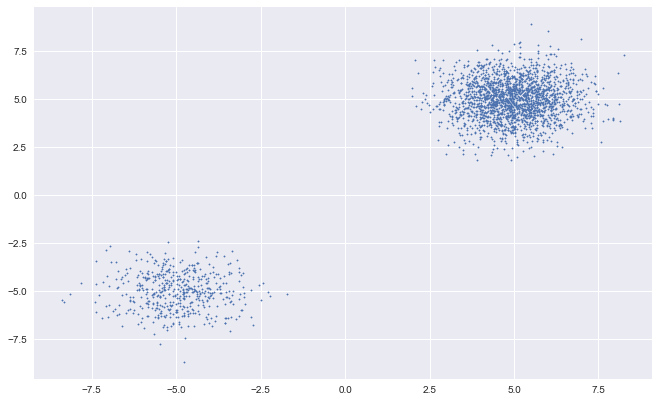

In [117]:
width, height = set_size(800)
fig, ax = plt.subplots(1, 1, figsize=(width, height))
ax.scatter(ds.ds[:, 0], ds.ds[:, 1], s=2)

In [139]:
def make_spirals(n_samples, noise_std=0., rotations=1.):
    ts = np.linspace(0, 1, n_samples)
    rs = ts ** 0.5
    thetas = rs * rotations * 2 * np.pi
    signs = np.random.randint(0, 2, (n_samples,)) * 2 - 1
    labels = (signs > 0).astype(int)

    xs = rs * signs * np.cos(thetas) + np.random.randn(n_samples) * noise_std
    ys = rs * signs * np.sin(thetas) + np.random.randn(n_samples) * noise_std
    points = np.stack([xs, ys], axis=1)
    return points, labels

points, labels = make_spirals(5000, noise_std=0.05, rotations=1.5)

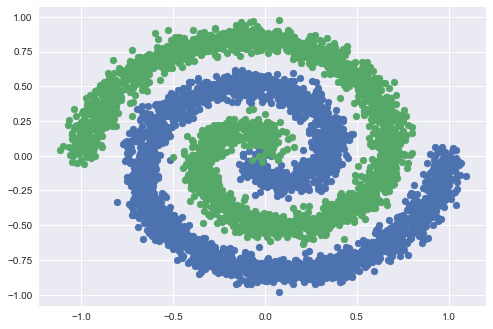

In [140]:
plt.scatter(points[np.where(labels == 0), 0], points[np.where(labels == 0), 1])
plt.scatter(points[np.where(labels == 1), 0], points[np.where(labels == 1), 1])

In [142]:
class ToyDataset:
    def __init__(self):
        self.size = 5_000
        rotations = 1.5
        noise_std = 0.05

        self.x, self.y = self._make_spirals(self.size, noise_std, rotations)

        self.ds_min = self.x.min()
        self.ds_max = self.x.max()

    def __len__(self):
        return self.size

    def _make_spirals(self, n_samples, noise_std=0.0, rotations=1.0):
        ts = np.linspace(0, 1, n_samples)
        rs = ts**0.5
        thetas = rs * rotations * 2 * np.pi
        signs = np.random.randint(0, 2, (n_samples,)) * 2 - 1
        labels = (signs > 0).astype(int)

        xs = rs * signs * np.cos(thetas) + np.random.randn(n_samples) * noise_std
        ys = rs * signs * np.sin(thetas) + np.random.randn(n_samples) * noise_std
        points = np.stack([xs, ys], axis=1)
        return points, labels

    def _normalize(self, pt):
        return (pt - self.ds_min) / (self.ds_max - self.ds_min)

    def __getitem__(self, idx):
        return {'x': self._normalize(self.x[idx]), 'y': self.y[idx]}

In [143]:
ds = ToyDataset()

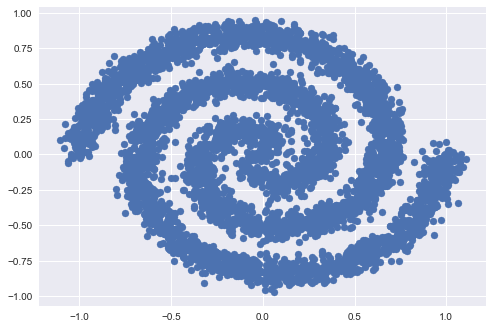

In [145]:
plt.scatter(ds.x[:, 0], ds.x[:, 1])

In [146]:
ds.y

array([0, 1, 0, ..., 0, 1, 1])

In [167]:
cd ../

/Users/gautam/Desktop/workbench/dojo


## MNIST Inference

In [168]:
import mnist.train as mnist

/Users/gautam/miniconda3/envs/dojo/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [186]:
import pathlib
import jax
import jax.numpy as jnp
from flax.training import checkpoints

class Config:
    learning_rate = 1e-3
    beta1 = 0.9
    beta2 = 0.999
    
config = Config
rng = jax.random.PRNGKey(0)

workdir = '/tmp/mnist12'
ckpt_dir = pathlib.Path(workdir) / 'checkpoints'
rng, init_rng = jax.random.split(rng)
state = mnist.create_train_state(init_rng, config)
state = checkpoints.restore_checkpoint(ckpt_dir, state)

train_dataset = torchvision.datasets.MNIST('/tmp/mnist', train=True, download=True)
im_labels = [(im, label) for im, label in train_dataset]
images, labels = zip(*im_labels)
images = jnp.array([np.array(im)[:, :, None] / 255.0 for im in images])
labels = jnp.array(labels)

In [188]:
logits = state.apply_fn({'params': state.params}, images)

In [189]:
logits.shape

(60000, 10)

In [194]:
import optax
from jax import nn

In [196]:
losses = optax.softmax_cross_entropy(logits=logits, labels=nn.one_hot(labels, num_classes=10))

In [206]:
loss = np.array(losses)
highloss = sorted(enumerate(loss), key=lambda x: x[1], reverse=True)

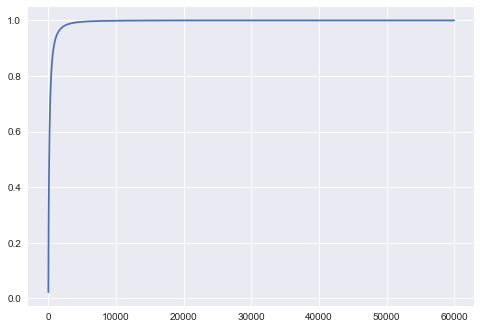

In [210]:
accumulation = np.cumsum(sorted(loss, reverse=True)) / np.sum(loss)
plt.plot(accumulation)

In [242]:
pred_labels = logits.argmax(-1)
accumulation[263]

0.7032602

In [219]:
highloss_idx, highloss_val = zip(*highloss)

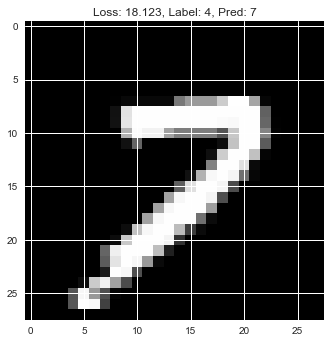

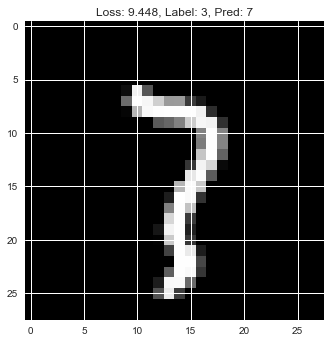

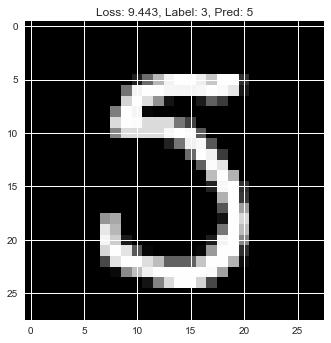

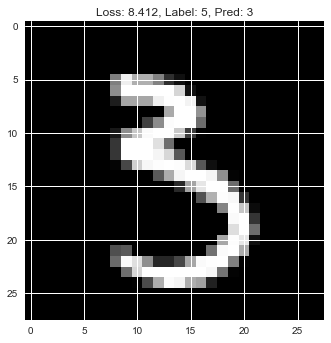

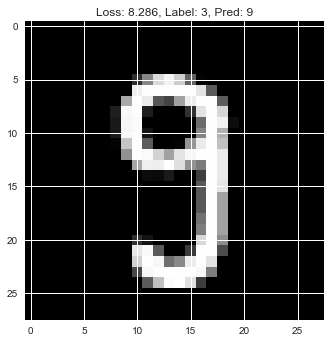

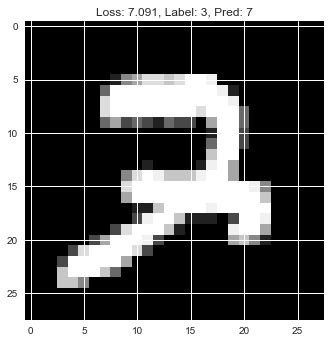

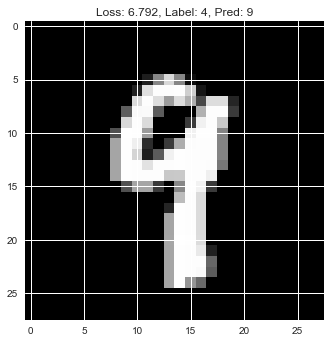

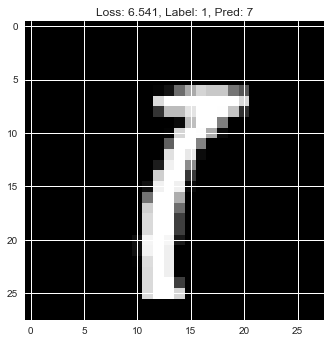

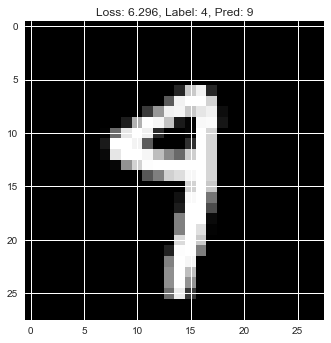

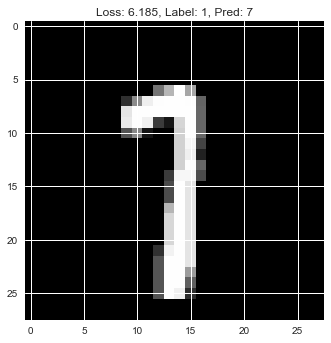

In [243]:
for i, idx in enumerate(highloss_idx[:10]):
    plt.imshow(1 - images[idx])
    plt.title(f'Loss: {highloss_val[i]:.3f}, Label: {labels[idx]}, Pred: {pred_labels[idx]}')
    plt.show()

In [323]:
from jax import vjp

def vgrad(f, x):
    y, vjp_fn = vjp(f, x)
    return vjp_fn(jnp.ones(y.shape))[0]

def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

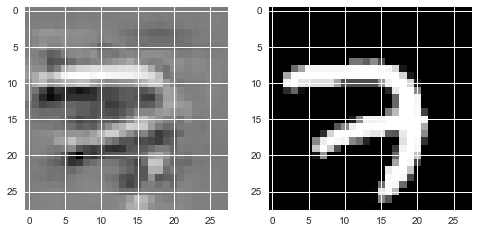

In [324]:
idx = 5000

z = lambda x: state.apply_fn({'params': state.params}, x)
attn = vgrad(z, images[idx][None])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(normalize(attn[0]))
axes[1].imshow(1-images[idx])

## CoordConv

In [385]:
import scipy.signal
import flax.linen as nn
from jax import lax
import functools

In [403]:
onehots = np.pad(
            np.eye(3136).reshape((3136, 56, 56, 1)),
            ((0, 0), (4, 4), (4, 4), (0, 0)),
            "constant",
        )

conv2d = jax.vmap(functools.partial(jax.scipy.signal.convolve2d, mode='same'), in_axes=(0, None))
images = np.array(conv2d(onehots[:, :, :, 0], np.ones((9, 9))))

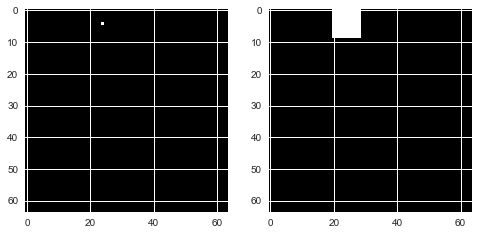

In [405]:
idx = 20
fig, axes = plt.subplots(1, 2)
axes[0].imshow(1 - onehots[idx])
axes[1].imshow(1 - images[idx])

In [411]:
np.where(onehots[1] == 1)

(array([4]), array([5]), array([0]))